https://www.kaggle.com/mlg-ulb/creditcardfraud

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [100]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

In [93]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

In [55]:
from keras import backend
print(backend.tensorflow_backend._get_available_gpus())

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

['/job:localhost/replica:0/task:0/device:GPU:0']
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10707022714148422244
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1437731635
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2526646508532419178
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
df = pd.read_csv('creditcard.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [9]:
fraud = df[df['Class']==1]
normal = df[df['Class']==0]

<Figure size 1440x720 with 0 Axes>

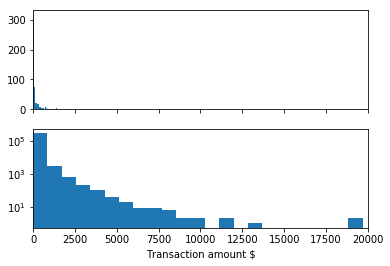

In [89]:
f = plt.figure(figsize=(20, 10))
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.hist(fraud['Amount'], bins=30)
ax2.hist(normal['Amount'], bins=30)
plt.xlim([0, 20000])
plt.yscale('log')
plt.xlabel('Transaction amount $');

In [28]:
train, test = train_test_split(df, test_size=0.2, stratify=df.Class, random_state=2019)

train.shape, test.shape

((227845, 31), (56962, 31))

In [29]:
X_train = train.drop('Class', 1)
y_train = train['Class']

X_train.shape, y_train.shape

((227845, 30), (227845,))

In [30]:
X_test = test.drop('Class', 1)
y_test = test['Class']

X_test.shape, y_test.shape

((56962, 30), (56962,))

In [31]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Полносвязная нейронная сеть

In [47]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=30))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 12,753
Trainable params: 12,753
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
history = model.fit(X_train, y_train, batch_size=500, epochs=50, verbose=1, validation_data=(X_test, y_test))

Train on 227845 samples, validate on 56962 samples
Epoch 1/50
227845/227845 [==============================] - 16s 70us/step - loss: 0.0801 - acc: 0.9968 - val_loss: 0.0261 - val_acc: 0.9983
Epoch 2/50
227845/227845 [==============================] - 6s 28us/step - loss: 0.0197 - acc: 0.9983 - val_loss: 0.0124 - val_acc: 0.9983
Epoch 3/50
227845/227845 [==============================] - 6s 28us/step - loss: 0.0093 - acc: 0.9984 - val_loss: 0.0079 - val_acc: 0.9986
Epoch 4/50
227845/227845 [==============================] - 6s 28us/step - loss: 0.0069 - acc: 0.9988 - val_loss: 0.0065 - val_acc: 0.9989
Epoch 5/50
227845/227845 [==============================] - 6s 27us/step - loss: 0.0060 - acc: 0.9990 - val_loss: 0.0059 - val_acc: 0.9991
Epoch 6/50
227845/227845 [==============================] - 6s 27us/step - loss: 0.0055 - acc: 0.9991 - val_loss: 0.0055 - val_acc: 0.9993
Epoch 7/50
227845/227845 [==============================] - 6s 28us/step - loss: 0.0051 - acc: 0.9992 - val_loss: 

In [56]:
score = model.evaluate(X_test, y_test, verbose=0)

score

[0.0033418126358112313, 0.9994733330992591]

In [59]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

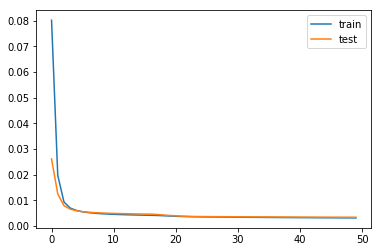

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test']);

In [65]:
prediction = model.predict_proba(X_test)
y_pred = (prediction > 0.5)*1

In [70]:
result_df = pd.DataFrame({'proba' : prediction.flatten(), 
                          'predicted_class' : y_pred.flatten(), 
                          'true_class' : y_test})

In [74]:
result_df[result_df['true_class']==1].head()

,proba,predicted_class,true_class
150662,0.969042,1,1
68067,0.003095,0,1
15566,0.905924,1,1
244333,0.831540,1,1
102444,0.996037,1,1


In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.90      0.78      0.84        98

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.95      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962



### Регуляризация

- L1
- L2
- Dropout ==> _по сути, ансамбль большого количества нейронных сетей_

https://keras.io/regularizers/

In [107]:
def baseline_model():
    model = Sequential()
    # model.add(Dense(128, activation='relu', input_shape=(30, ), kernel_regularizer=regularizers.l2(1e-5)))
    model.add(Dense(128, activation='relu', input_shape=(30, )))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 128)               3968      
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 9         
Total params: 12,753
Trainable params: 12,753
Non-trainable params: 0
_________________________________________________________________


In [83]:
history = model.fit(X_train, y_train, batch_size=500, epochs=50, verbose=1, validation_data=(X_test, y_test))

Train on 227845 samples, validate on 56962 samples
Epoch 1/50
227845/227845 [==============================] - 7s 32us/step - loss: 0.0972 - acc: 0.9964 - val_loss: 0.0308 - val_acc: 0.9983
Epoch 2/50
227845/227845 [==============================] - 6s 26us/step - loss: 0.0291 - acc: 0.9983 - val_loss: 0.0248 - val_acc: 0.9983
Epoch 3/50
227845/227845 [==============================] - 6s 25us/step - loss: 0.0246 - acc: 0.9983 - val_loss: 0.0211 - val_acc: 0.9983
Epoch 4/50
227845/227845 [==============================] - 5s 22us/step - loss: 0.0208 - acc: 0.9983 - val_loss: 0.0155 - val_acc: 0.9983
Epoch 5/50
227845/227845 [==============================] - 5s 23us/step - loss: 0.0153 - acc: 0.9983 - val_loss: 0.0107 - val_acc: 0.9983
Epoch 6/50
227845/227845 [==============================] - 5s 22us/step - loss: 0.0118 - acc: 0.9983 - val_loss: 0.0081 - val_acc: 0.9983
Epoch 7/50
227845/227845 [==============================] - 5s 23us/step - loss: 0.0094 - acc: 0.9984 - val_loss: 0

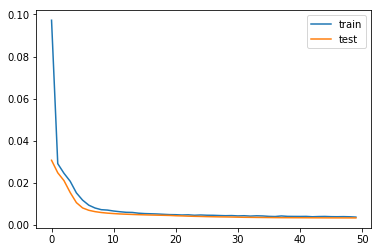

In [85]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test']);

### Методы оптимизации

https://habr.com/ru/post/318970/

- метод адаптивной инерции

### Функции потерь

In [87]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56878
           1       0.78      0.90      0.84        84

   micro avg       1.00      1.00      1.00     56962
   macro avg       0.89      0.95      0.92     56962
weighted avg       1.00      1.00      1.00     56962



### Callbacks

- early stopping

In [ ]:
model = baseline_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

### Кросс-валидация

In [108]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('MLP', KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=32, verbose=0)))

pipeline = Pipeline(estimators)

In [109]:
kfold = StratifiedKFold(n_splits=5, random_state=2019)
results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='f1')

print('Metrics: ', results.mean(), results.std())

Metrics:  0.808875604584415 0.03409332943605331
